In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import os
import glob

# Useful methods

In [2]:
def true_labels(class_curves):
    y_true_ade = []
    y_true_hip = []
    y_true_ser = []
    y_true = []

    if(class_curves=="adenoma"):
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(1)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(0)
            
    elif(class_curves=="hiperplastic"):
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(1)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(0)
    else:
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(1)
    y_true.extend(y_true_ade)
    y_true.extend(y_true_hip)
    y_true.extend(y_true_ser)
    return y_true

In [3]:
def roc_auc_values(roc, y_pred, y_true):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred) #,pos_label=2)
    auc = roc_auc_score(y_true, y_pred)
    
    return fpr, tpr, auc

In [4]:
def plot_roc(fpr, tpr, auc):
    
    fig, ax = plt.subplots()
    plt.title(label="ROC polyps types", loc='center')
    ax.plot(fpr[0], tpr[0], label= "adenoma"+", auc="+'%.3f' % auc[0])
    ax.plot(fpr[1], tpr[1], label= "hyperplastic"+", auc="+'%.3f' % auc[1])
    ax.plot(fpr[2], tpr[2], label= "serrated"+", auc="+'%.3f' % auc[2])
    
    axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 2, loc=1 for upper right
    axins.plot(fpr[0], tpr[0], fpr[1], tpr[1], fpr[2], tpr[2])
    axins.set_xlim(0, 0.25) # Limit the region for zoom
    axins.set_ylim(0.5, 0.8)
    
    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)

    mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")

    ax.legend(loc=0)
    #plt.savefig('roc-auc-fakeNbiPolyps.png')

In [43]:
path = '../data/WL/adenomaWl.csv'
ade = pd.read_csv(path, header = None)
ade.columns = ['path', 'label']
ade.groupby(by='label').count()

,path
label,
adenoma,23479


## Adenoma

In [5]:
path_ade = 'predict-adenomaAugmentedWl.csv'
ade_df = pd.read_csv(path_ade, header= None, thousands=',')
ade_df = ade_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
ade_df["GroundTruth"] = 0 
ade_df["Num_video"] = 0
#funcion lambda (para tomar el # del frame): para toda x tal que en la colum Video se parta por '/'
#se toma la última palabra y de esta lo que este por delante (5 cantidad de letras en 'video')
ade_df["Num_video"] = (ade_df.apply(lambda x: int(x.Video.split('/')[-1][6:]), axis=1))
ade_df = ade_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
ade_df['Prob_ser'] = pd.to_numeric(ade_df['Prob_ser'], downcast='float', errors='coerce').fillna(1 - ade_df.Prob_ade - ade_df.Prob_hyp)
ade_df = ade_df.reset_index(drop = True)#para que los indices de las filas esten acorde al nuevo orden
ade_df

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,adenoma_WL/video_01,0,0.005168,0.000328,0.994504,0,1
1,adenoma_WL/video_01,1,0.004740,0.000307,0.994953,0,1
2,adenoma_WL/video_01,2,0.009515,0.000869,0.989616,0,1
3,adenoma_WL/video_01,3,0.003644,0.000411,0.995945,0,1
4,adenoma_WL/video_01,4,0.003572,0.000336,0.996092,0,1
...,...,...,...,...,...,...,...
23473,adenoma_WL/video_40,456,0.999675,0.000002,0.000323,0,40
23474,adenoma_WL/video_40,457,0.999262,0.000013,0.000725,0,40
23475,adenoma_WL/video_40,458,0.999435,0.000010,0.000555,0,40
23476,adenoma_WL/video_40,459,0.078729,0.044187,0.877084,0,40


## Hyperplastic

In [6]:
path_hyp = 'predict-hyperplasticAugmentedWl.csv'
hyp_df = pd.read_csv(path_hyp, header= None, thousands=',')
hyp_df = hyp_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
hyp_df["GroundTruth"] = 1 
hyp_df["Num_video"] = 0
hyp_df["Num_video"] = (hyp_df.apply(lambda x: int(x.Video.split('/')[-1][6:]), axis=1))
hyp_df = hyp_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
hyp_df = hyp_df.reset_index(drop = True)
hyp_df

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,hiperplastic_WL/video_41,1,0.000255,0.999236,0.000509,1,41
1,hiperplastic_WL/video_41,2,0.000255,0.999231,0.000514,1,41
2,hiperplastic_WL/video_41,3,0.000928,0.997780,0.001292,1,41
3,hiperplastic_WL/video_41,4,0.001166,0.996619,0.002215,1,41
4,hiperplastic_WL/video_41,5,0.001471,0.997126,0.001403,1,41
...,...,...,...,...,...,...,...
7417,hiperplastic_WL/video_61,271,0.833934,0.160935,0.005130,1,61
7418,hiperplastic_WL/video_61,272,0.903684,0.089460,0.006856,1,61
7419,hiperplastic_WL/video_61,273,0.595206,0.400775,0.004019,1,61
7420,hiperplastic_WL/video_61,274,0.049515,0.912260,0.038225,1,61


## Serrated

In [7]:
path_ser = 'predict-serratedAugmentedWl.csv'
ser_df = pd.read_csv(path_ser, header= None, thousands=',')
ser_df = ser_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
ser_df["GroundTruth"] = 2 
ser_df["Num_video"] = 0
ser_df["Num_video"] = (ser_df.apply(lambda x: int(x.Video.split('/')[-1][6:]), axis=1))
ser_df = ser_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
ser_df = ser_df.reset_index(drop = True)
ser_df

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,serrated_WL/video_62,1,0.709460,0.289230,0.001311,2,62
1,serrated_WL/video_62,2,0.710102,0.288573,0.001325,2,62
2,serrated_WL/video_62,3,0.128818,0.859829,0.011353,2,62
3,serrated_WL/video_62,4,0.005495,0.986692,0.007812,2,62
4,serrated_WL/video_62,5,0.048305,0.926732,0.024963,2,62
...,...,...,...,...,...,...,...
5626,serrated_WL/video_76,586,0.021734,0.975768,0.002498,2,76
5627,serrated_WL/video_76,587,0.028146,0.969228,0.002625,2,76
5628,serrated_WL/video_76,588,0.054537,0.937886,0.007577,2,76
5629,serrated_WL/video_76,589,0.223745,0.691573,0.084682,2,76


## Concatenate

In [8]:
total_df = pd.concat([ade_df, hyp_df, ser_df])
total_df = total_df.reset_index(drop = True)
total_df

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,adenoma_WL/video_01,0,0.005168,0.000328,0.994504,0,1
1,adenoma_WL/video_01,1,0.004740,0.000307,0.994953,0,1
2,adenoma_WL/video_01,2,0.009515,0.000869,0.989616,0,1
3,adenoma_WL/video_01,3,0.003644,0.000411,0.995945,0,1
4,adenoma_WL/video_01,4,0.003572,0.000336,0.996092,0,1
...,...,...,...,...,...,...,...
36526,serrated_WL/video_76,586,0.021734,0.975768,0.002498,2,76
36527,serrated_WL/video_76,587,0.028146,0.969228,0.002625,2,76
36528,serrated_WL/video_76,588,0.054537,0.937886,0.007577,2,76
36529,serrated_WL/video_76,589,0.223745,0.691573,0.084682,2,76


## Analysis

In [9]:
predictions_total_df = pd.DataFrame(columns=["video", 'Num_video',"Prob_ade", "Prob_hyp", "Prob_ser", 
                                             "GroundTruth",'Pred','WellPred'])
class_dict = {0:"adenoma_WL", 1:"hiperplastic_WL", 2:"serrated_WL/video15"}
for groundtruth in range(3):
    for num_video in total_df[total_df["GroundTruth"]== groundtruth].Num_video.unique():
        current_df = total_df[(total_df['Num_video']==num_video) & (total_df['GroundTruth']==groundtruth)]
        predictions_total_df.loc[len(predictions_total_df)] = [class_dict[groundtruth]+"video"+str(num_video),
                                                               num_video,
                                                               current_df.Prob_ade.mean(),
                                                               current_df.Prob_hyp.mean(),
                                                               current_df.Prob_ser.mean(),
                                                               groundtruth,
                                                               0,
                                                               0]
predictions_total_df["Pred"] = (predictions_total_df.apply(
    lambda x: int(np.argmax(np.array([x.Prob_ade, x.Prob_hyp, x.Prob_ser]))), axis=1))
predictions_total_df["WellPred"] = (predictions_total_df.apply(
    lambda x: 1 if x.GroundTruth == x.Pred else 0, axis=1))

In [10]:
predictions_total_df

,video,Num_video,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Pred,WellPred
0,adenoma_WLvideo1,1,0.005668,0.001816,0.992516,0,2,0
1,adenoma_WLvideo2,2,0.333965,0.599504,0.066532,0,1,0
2,adenoma_WLvideo3,3,0.702808,0.268025,0.029167,0,0,1
3,adenoma_WLvideo4,4,0.303190,0.015800,0.681010,0,2,0
4,adenoma_WLvideo5,5,0.483898,0.253052,0.263050,0,0,1
...,...,...,...,...,...,...,...,...
71,serrated_WL/video15video72,72,0.001078,0.028799,0.970122,2,2,1
72,serrated_WL/video15video73,73,0.111709,0.786471,0.101820,2,1,0
73,serrated_WL/video15video74,74,0.964547,0.012520,0.022933,2,0,0
74,serrated_WL/video15video75,75,0.393882,0.560380,0.045738,2,1,0


In [11]:
totalScore = float(predictions_total_df.WellPred.sum()/len(predictions_total_df)*100)
print("Total score {:.3f}%".format(totalScore))

Total score 51.316%


## adenoma

In [12]:
adenoma_results_df = predictions_total_df[predictions_total_df['GroundTruth'] == 0]
adenomaScore = float(adenoma_results_df.WellPred.sum()/len(adenoma_results_df)*100)
print("Adenoma score {:.3f}%".format(adenomaScore))

Adenoma score 57.500%


In [13]:
adenoma_results_df.WellPred.sum()

23

## Hyperplastic

In [14]:
hyperplastic_results_df = predictions_total_df[predictions_total_df['GroundTruth'] == 1]
hyperplasticScore = float(hyperplastic_results_df.WellPred.sum()/len(hyperplastic_results_df)*100)
print("hyperplastic score {:.3f}%".format(hyperplasticScore))

hyperplastic score 52.381%


In [15]:
hyperplastic_results_df.WellPred.sum()

11

## Serrated

In [16]:
serrated_results_df = predictions_total_df[predictions_total_df['GroundTruth'] == 2]
serratedScore = float(serrated_results_df.WellPred.sum()/len(serrated_results_df)*100)
print("serrated score {:.3f}%".format(serratedScore))

serrated score 33.333%


In [17]:
serrated_results_df.WellPred.sum()

5

## Metrics 

In [18]:
y_true = predictions_total_df['GroundTruth'].values
y_true = y_true.tolist()
y_pred = predictions_total_df['Pred'].values
y_pred = y_pred.tolist()
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true')

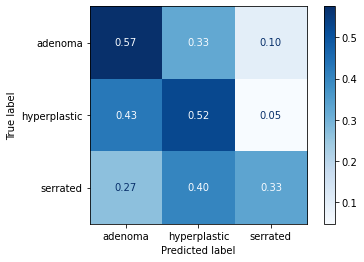

In [19]:
target_names = ['adenoma', 'hyperplastic', 'serrated']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='.2f')
#plt.savefig('confusion_matrix_art_Nbi_80.png')

### general report

In [20]:
print(metrics.classification_report(y_true, y_pred, target_names=["adenoma","hiperplastico", "serrated"]))

               precision    recall  f1-score   support

      adenoma       0.64      0.57      0.61        40
hiperplastico       0.37      0.52      0.43        21
     serrated       0.50      0.33      0.40        15

     accuracy                           0.51        76
    macro avg       0.50      0.48      0.48        76
 weighted avg       0.54      0.51      0.52        76



### ROC-AUC values

In [21]:
fpr, tpr, auc = ([] for _ in range(3))
roc_curves = ["adenoma", "hiperplastic", "serrated"]
for roc in roc_curves:
    if roc=="adenoma":
        y_pred = total_df['Prob_ade'].values        
        y_true = true_labels(roc)
        ade_fpr, ade_tpr, ade_auc = roc_auc_values(roc, y_pred, y_true)
    elif roc=="hiperplastic":
        y_pred = total_df['Prob_hyp'].values
        y_true = true_labels(roc)
        hyp_fpr, hyp_tpr, hyp_auc = roc_auc_values(roc, y_pred, y_true)
    else:
        y_pred = total_df['Prob_ser'].values
        y_true = true_labels(roc)
        ser_fpr, ser_tpr, ser_auc = roc_auc_values(roc, y_pred, y_true)
        
fpr.append(ade_fpr)
fpr.append(hyp_fpr)
fpr.append(ser_fpr)

tpr.append(ade_tpr)
tpr.append(hyp_tpr)
tpr.append(ser_tpr)

auc.append(ade_auc)
auc.append(hyp_auc)
auc.append(ser_auc)

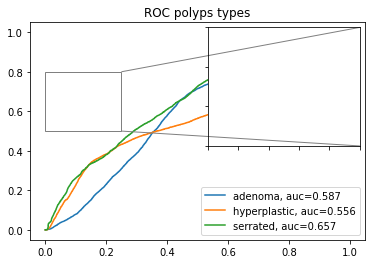

In [22]:
plot_roc(fpr, tpr, auc)